# Traffic accident severity prediction task

Code of the following paper: 

Traffic Accident Prediction using Graph Neural Networks: New Datasets and the TRAVEL Model. Baixiang Huang, Bryan Hooi.

In [1]:
import os
import math
import time
import shutil
import pickle
import warnings
import numpy as np
import osmnx as ox
import pandas as pd
import os.path as osp
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch_geometric
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from torch import Tensor
from torch.nn import Parameter
from torch_geometric.io import read_npz
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset, uniform, zeros
from torch_geometric.typing import OptTensor, OptPairTensor, Adj, Size
from torch_geometric.data import Data, DataLoader, InMemoryDataset, download_url

from pylab import cm
from matplotlib import colors
from IPython.display import clear_output
from xgboost.sklearn import XGBClassifier
from typing import Union, Tuple, Callable, Optional
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

np.random.seed(7)
torch.manual_seed(7)
plt.style.use("ggplot")
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
print('CUDA version:', torch.version.cuda)
print('PyTorch version:', torch.__version__)
print('PyG version:', torch_geometric.__version__)

CUDA version: 10.2
PyTorch version: 1.10.1
PyG version: 2.0.4


## Define functions

In [3]:
def read_npz(path):
    with np.load(path, allow_pickle=True) as f:
        return parse_npz(f)


def parse_npz(f):
    "Set up severity prediction task here: use severity_labels as labels"
    x = torch.from_numpy(f['x']).to(torch.float)
    y = torch.from_numpy(f['y']).to(torch.long)
    edge_attr = torch.from_numpy(f['edge_attr']).to(torch.float)
    edge_index = torch.from_numpy(f['edge_index']).to(torch.long).t().contiguous()
    edge_attr_dir = torch.from_numpy(f['edge_attr_dir']).to(torch.float)
    edge_attr_ang = torch.from_numpy(f['edge_attr_ang']).to(torch.float)
    coords = torch.from_numpy(f['coordinates']).to(torch.float)
    severity_labels = torch.from_numpy(f['severity_labels']).to(torch.long)
    return Data(x=x, y=severity_labels, edge_index=edge_index, edge_attr=edge_attr, 
                edge_attr_dir=edge_attr_dir, edge_attr_ang=edge_attr_ang, 
                coords=coords, severity_labels=severity_labels)


def train_test_split_stratify(dataset, train_ratio, val_ratio, class_num):
    labels = dataset[0].y
    train_mask = torch.zeros(size=labels.shape, dtype=bool)
    val_mask = torch.zeros(size=labels.shape, dtype=bool)
    test_mask = torch.zeros(size=labels.shape, dtype=bool)
    for i in range(class_num):
        stratify_idx = np.argwhere(labels.numpy() == i).flatten()
        np.random.shuffle(stratify_idx)
        split1 = int(len(stratify_idx) * train_ratio)
        split2 = split1 + int(len(stratify_idx) * val_ratio)
        train_mask[stratify_idx[:split1]] = True 
        val_mask[stratify_idx[split1:split2]] = True
        test_mask[stratify_idx[split2:]] = True
    
    highest = pd.DataFrame(labels).value_counts().head().iloc[0]
    # print("Null Accuracy:", highest / (len(labels)))
    return train_mask, val_mask, test_mask

In [4]:
class TRAVELDataset(InMemoryDataset):
    r"""
    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The name of the dataset.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """
    url = 'https://github.com/baixianghuang/travel/raw/main/dataset/{}.npz'
    
    def __init__(self, root: str, name: str,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.name = name.lower()
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> str:
        return f'{self.name}.npz'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        download_url(self.url.format(self.name), self.raw_dir)

    def process(self):
        data = read_npz(self.raw_paths[0])
        data = data if self.pre_transform is None else self.pre_transform(data)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name.capitalize()}Full()'

In [5]:
class TRAVELConv(MessagePassing):
    """
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        nn (torch.nn.Module): A neural network that
            maps feature data of shape :obj:`[-1,
            num_node_features + num_edge_features]` to shape
            :obj:`[-1, new_dimension]`, *e.g.*, defined by
            :class:`torch.nn.Sequential`.
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"add"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add the transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, nn: Callable, aggr: str = 'add',
                 root_weight: bool = True, bias: bool = True, **kwargs):
        super(TRAVELConv, self).__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
            
        self.in_channels_l = in_channels[0]

        if root_weight:
            self.root = Parameter(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)
        if self.root is not None:
            uniform(self.root.size(0), self.root)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None and self.root is not None:
            out += torch.matmul(x_r, self.root)

        if self.bias is not None:
            out += self.bias
        return out


    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: Tensor) -> Tensor:     
        inputs = torch.cat([x_j, edge_attr], dim=1)
        return self.nn(inputs)

    def __repr__(self):
        return '{}({}, {}, aggr="{}", nn={})'.format(self.__class__.__name__,
                                                     self.in_channels,
                                                     self.out_channels,
                                                     self.aggr, self.nn)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()

    
@torch.no_grad()
def test(model, data):
    model.eval()
    logits, measures = model().detach(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        mea = f1_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
        measures.append(mea)
    label_pred = logits.max(1)[1]

    mask = data.test_mask
    scores = logits[mask][:, 1]
    pred = logits[mask].max(1)[1]
    test_y = data.y[mask]
    
    test_acc = pred.eq(test_y).sum().item() / mask.sum().item()
    return measures, label_pred, test_acc


def train_loop(model, data, optimizer, num_epochs, model_name='test'):
    epochs, train_measures, valid_measures, test_measures, test_accs = [], [], [], [], []
    coords = data.coords.cpu().numpy()
    gdf_pred = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1]})
    for epoch in range(num_epochs):
        train(model, data, optimizer)
        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        measures, label_pred, test_acc = test(model, data)
        train_mea, valid_mea, test_mea = measures
        epochs.append(epoch)
        train_measures.append(train_mea)
        valid_measures.append(valid_mea)
        test_measures.append(test_mea)
        test_accs.append(test_acc)
        
        if epoch % 20 == 0:
            clear_output(True)
            fig, (ax1, ax) = plt.subplots(1, 2, figsize=(30, 12))  
            gdf_pred['label'] = label_pred.cpu().numpy()
            for i in range(class_num):
                G = nx.MultiGraph()
                G.add_nodes_from(gdf_pred[gdf_pred['label'] == i].index)
                sub1 = nx.draw(G, pos=pos_dict, ax=ax1, node_color=colors.rgb2hex(cmap(i)), node_size=10, label=i)

            ax.text(1, 1, log.format(epoch, train_measures[-1], valid_measures[-1], test_measures[-1]), fontsize=18)
            ax.plot(epochs, train_measures, "r", epochs, valid_measures, "g", epochs, test_measures, "b")
            ax.set_ylim([0, 1])
            ax.legend(["train", "valid", "test"])  
            norm = colors.BoundaryNorm(boundaries=range(8), ncolors=8)
            plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax1, orientation='vertical', label='Severity') 
            ax1.set_title(model_name, y=-0.01)
            plt.show()

    select_idx = np.argmax(valid_measures[num_epochs//2:]) + num_epochs//2
    final_test_mea = np.array(test_measures)[select_idx]
    final_test_acc = np.array(test_accs)[select_idx]
    print('F measure {:.5f} | Test Accuracy {:.5f}'.format(final_test_mea, final_test_acc))
    return (round(final_test_mea*100, 2), round(final_test_acc*100, 2))

## Load data

In [7]:
# cities_sorted_by_accident.pkl is available in the directory util
# with open('dataset/cities_sorted_by_accident.pkl', 'rb') as fp:
#     all_city_ls = pickle.load(fp)
    
# print('# cities:', len(all_city_ls))
# for e in all_city_ls[:50]:
#     print(e[0]+' ('+e[1]+')', end = ', ')

In [8]:
exp = [('Houston', 'TX'), ('Charlotte', 'NC'), ('Dallas', 'TX'), ('Austin', 'TX'),
       ('Los Angeles', 'CA'), ('Atlanta', 'GA'), ('Seattle', 'WA'), ('Chicago', 'IL')]
e = exp[2]
cnt = 0

city_name, state_abbrev = e[0].lower().replace(" ", "_"), e[1].lower()
if os.path.exists('dataset/dataset_travel_all/exp/'+city_name+'_'+state_abbrev+'/processed'):
    shutil.rmtree('dataset/dataset_travel_all/exp/'+city_name+'_'+state_abbrev+'/processed')

dataset_city = TRAVELDataset('dataset/dataset_travel_all/exp/', city_name+'_'+state_abbrev)
dataset = dataset_city
data = dataset_city[0]
class_num = dataset.num_classes

print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# 60%, 20% and 20% for training, validation and test
data.train_mask, data.val_mask, data.test_mask = train_test_split_stratify(dataset_city, train_ratio=0.6, val_ratio=0.2, class_num=class_num)
sc = MinMaxScaler()  
data.x[data.train_mask] = torch.tensor(sc.fit_transform(data.x[data.train_mask]), dtype=torch.float)
data.x[data.val_mask] = torch.tensor(sc.transform(data.x[data.val_mask]), dtype=torch.float)
data.x[data.test_mask] = torch.tensor(sc.transform(data.x[data.test_mask]), dtype=torch.float)

edge_attr_all = MinMaxScaler().fit_transform(data.edge_attr.cpu())  
edge_attr_all = torch.tensor(edge_attr_all).float().to(device)

Processing...
Done!


Number of graphs: 1
Number of node features: 10
Number of edge features: 17
Number of classes: 8
Number of nodes: 36022
Number of edges: 92117
Average node degree: 2.56
Contains isolated nodes: False
Contains self-loops: True
Is undirected: False


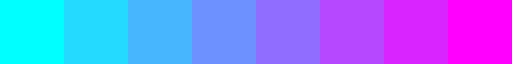

In [9]:
def draw_with_labels(df_nodes, model_name='test'):
    plt.figure(figsize=(6, 5)) 
    for i in range(class_num):
        G = nx.MultiGraph()
        G.add_nodes_from(df_nodes[df_nodes['label'] == i].index)
        nx.draw(G, pos=pos_dict, node_color=colors.rgb2hex(cmap(i)), node_size=3, label=i)
    norm = colors.BoundaryNorm(boundaries=range(8), ncolors=8)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Severity')
    plt.title(model_name, y=-0.01)
    plt.show()

coords = data.coords.numpy()
df_nodes = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'label': data.y.numpy()}) 
zip_iterator = zip(df_nodes.index, df_nodes[['x', 'y']].values)
pos_dict = dict(zip_iterator)
cmap = cm.get_cmap('cool', class_num)
cmap

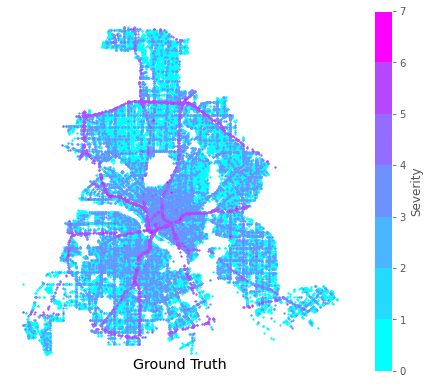

In [10]:
draw_with_labels(df_nodes, 'Ground Truth')

## Train

In [11]:
d = 16  # number of hidden units
all_res = []
num_epochs = 301

F measure 0.66002 | Test Accuracy 0.72705
Execution time: 2.1600 seconds


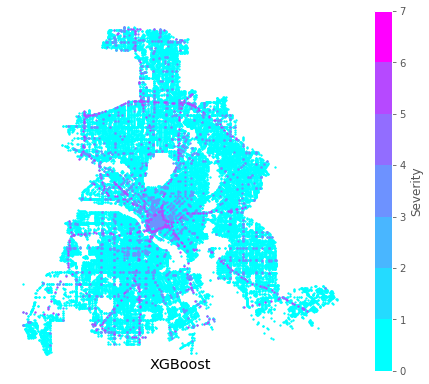

In [12]:
X_train, X_test, y_train, y_test = data.x[data.train_mask].cpu().numpy(), data.x[data.test_mask].cpu().numpy(), data.y[data.train_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy()
start_time = time.time()
xgb_clf = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
test_acc, test_f1 = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')
print('F measure {:.5f} | Test Accuracy {:.5f}'.format(test_f1, test_acc))
res = (round(test_f1*100, 2), round(test_acc*100, 2))
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('XGBoost',) + res + (t,))
print("Execution time: %.4f seconds" % t)

cnt += 1
y_pred_all = xgb_clf.predict(data.x.cpu().numpy())
df_pred = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'label': y_pred_all}) 
draw_with_labels(df_pred, 'XGBoost')

In [13]:
data = data.to(device)
device

device(type='cuda')

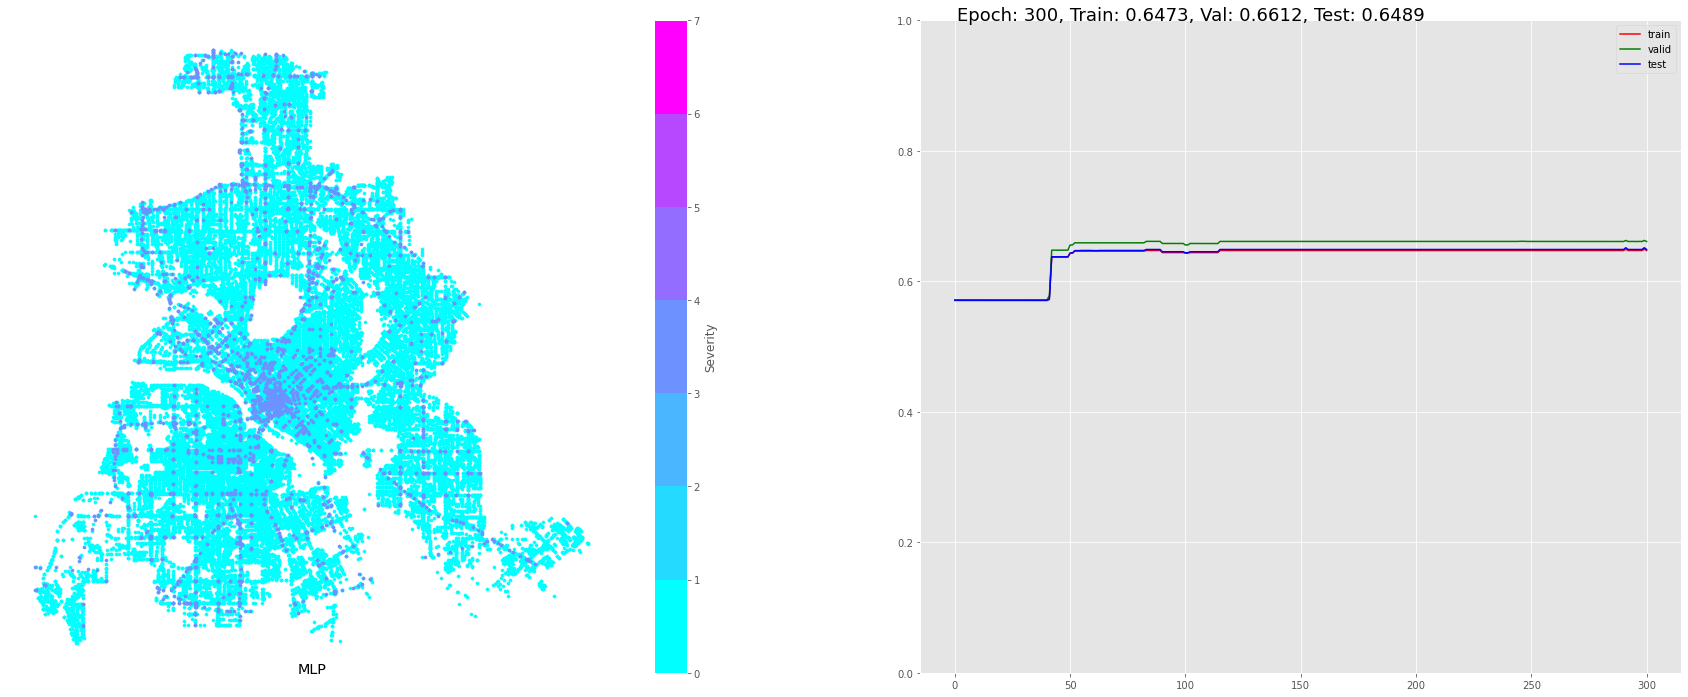

F measure 0.65160 | Test Accuracy 0.72275
Execution time: 17.0600 seconds


In [14]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=d):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dataset.num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x = F.relu(self.fc1(data.x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = MLP().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'MLP')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('MLP',) + res + (t,))
print("Execution time: %.4f seconds" % t)

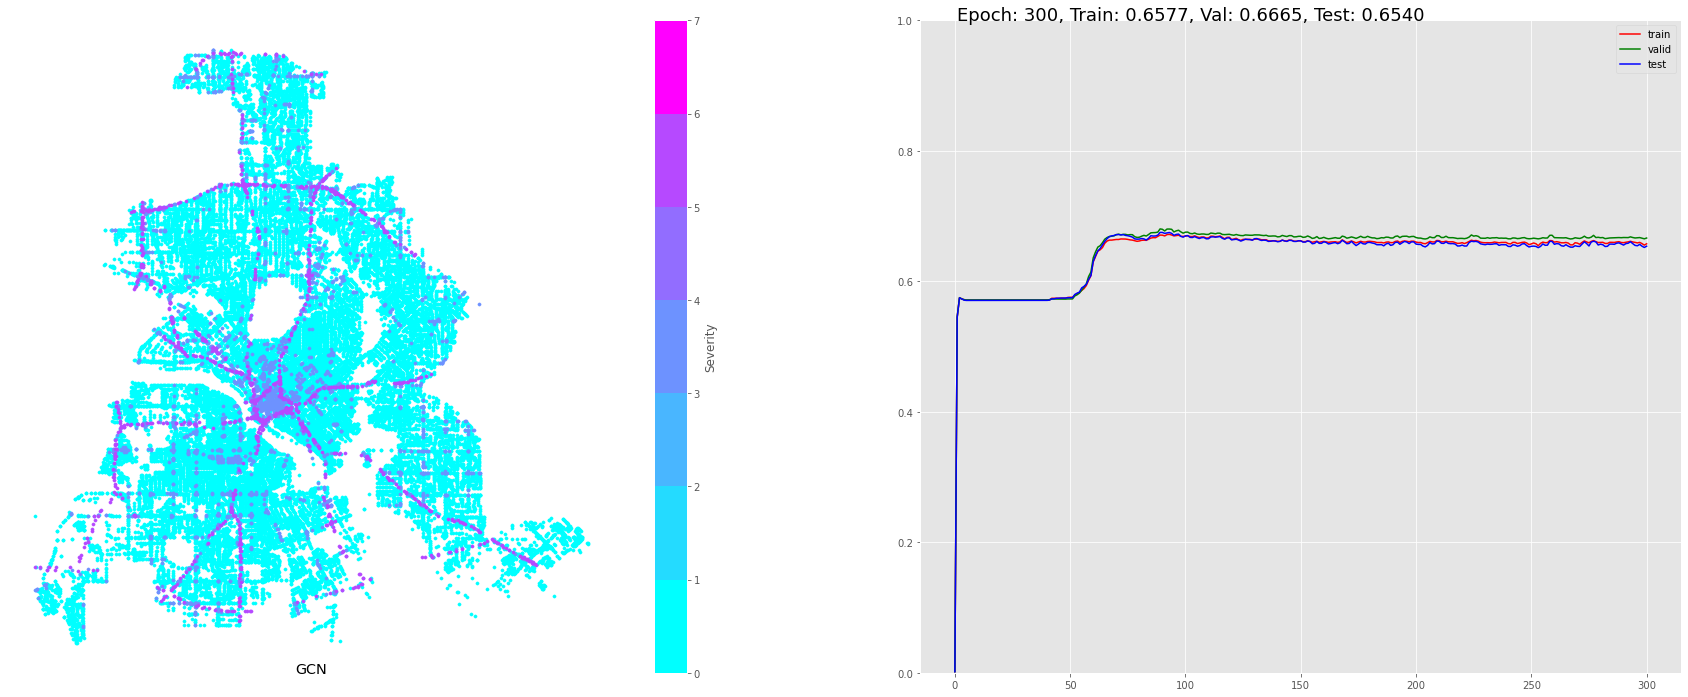

F measure 0.66161 | Test Accuracy 0.71886
Execution time: 15.2800 seconds


In [15]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GCN')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('GCN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

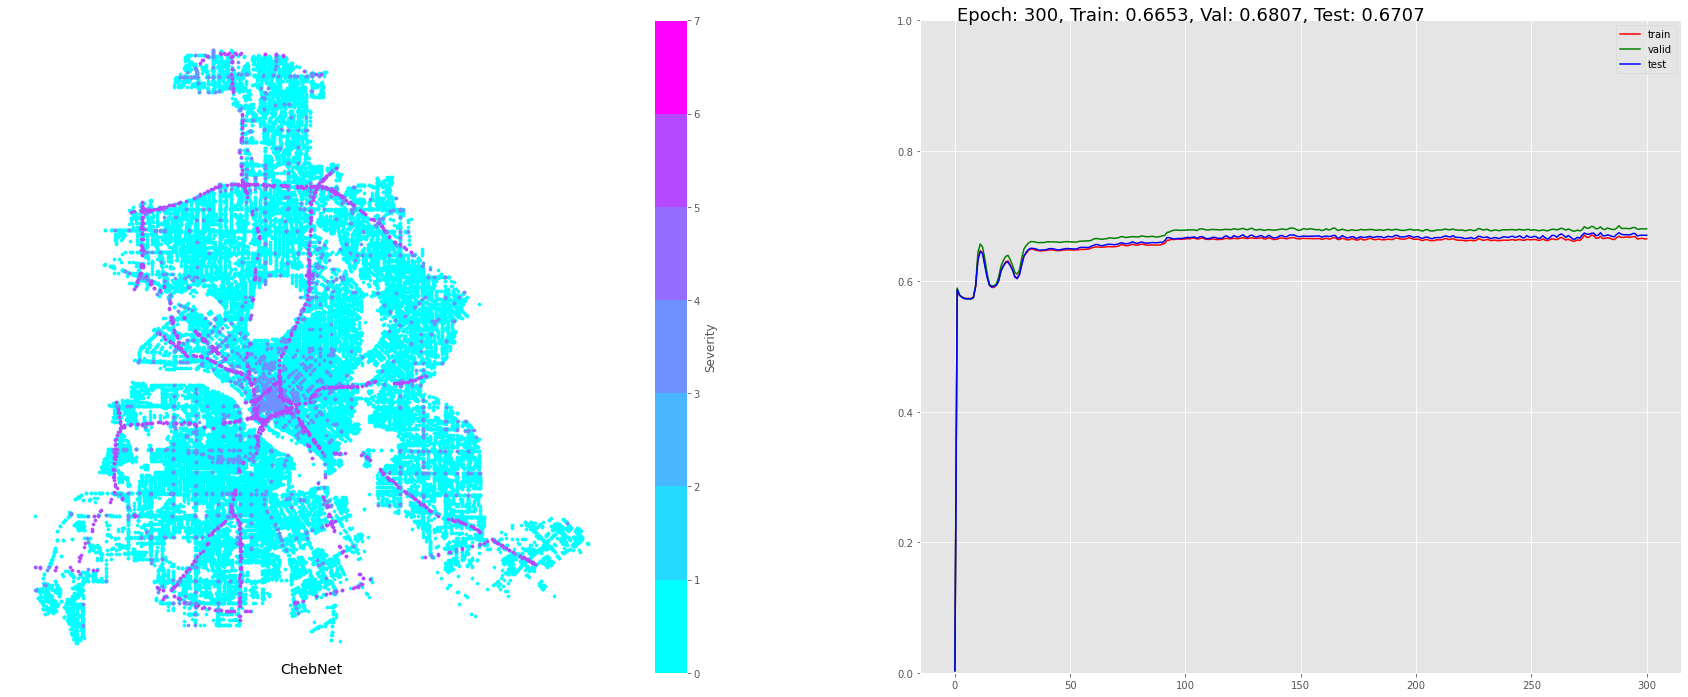

F measure 0.67465 | Test Accuracy 0.73245
Execution time: 14.5300 seconds


In [16]:
class ChebNet(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(ChebNet, self).__init__()
        self.conv1 = pyg_nn.ChebConv(dataset.num_features, hidden_dim, K=2)
        self.conv2 = pyg_nn.ChebConv(hidden_dim, hidden_dim, K=2)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = ChebNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'ChebNet')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('ChebNet',) + res + (t,))
print("Execution time: %.4f seconds" % t)

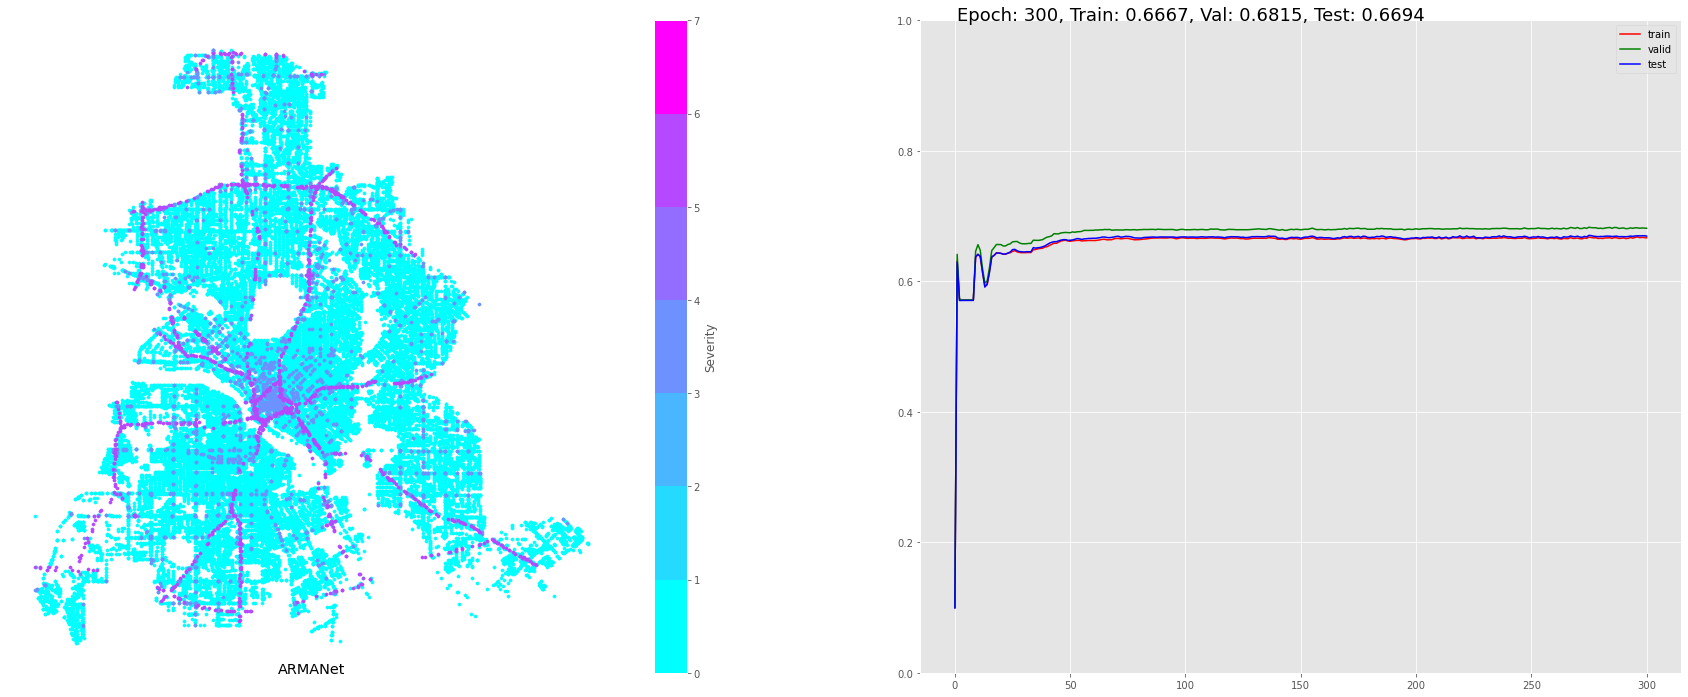

F measure 0.67060 | Test Accuracy 0.73065
Execution time: 13.9100 seconds


In [17]:
class ARMANet(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(ARMANet, self).__init__()
        self.conv1 = pyg_nn.ARMAConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.ARMAConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = ARMANet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'ARMANet')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),)  + (e[0]+' '+e[1],)+ ('ARMANet',) + res + (t,))
print("Execution time: %.4f seconds" % t)

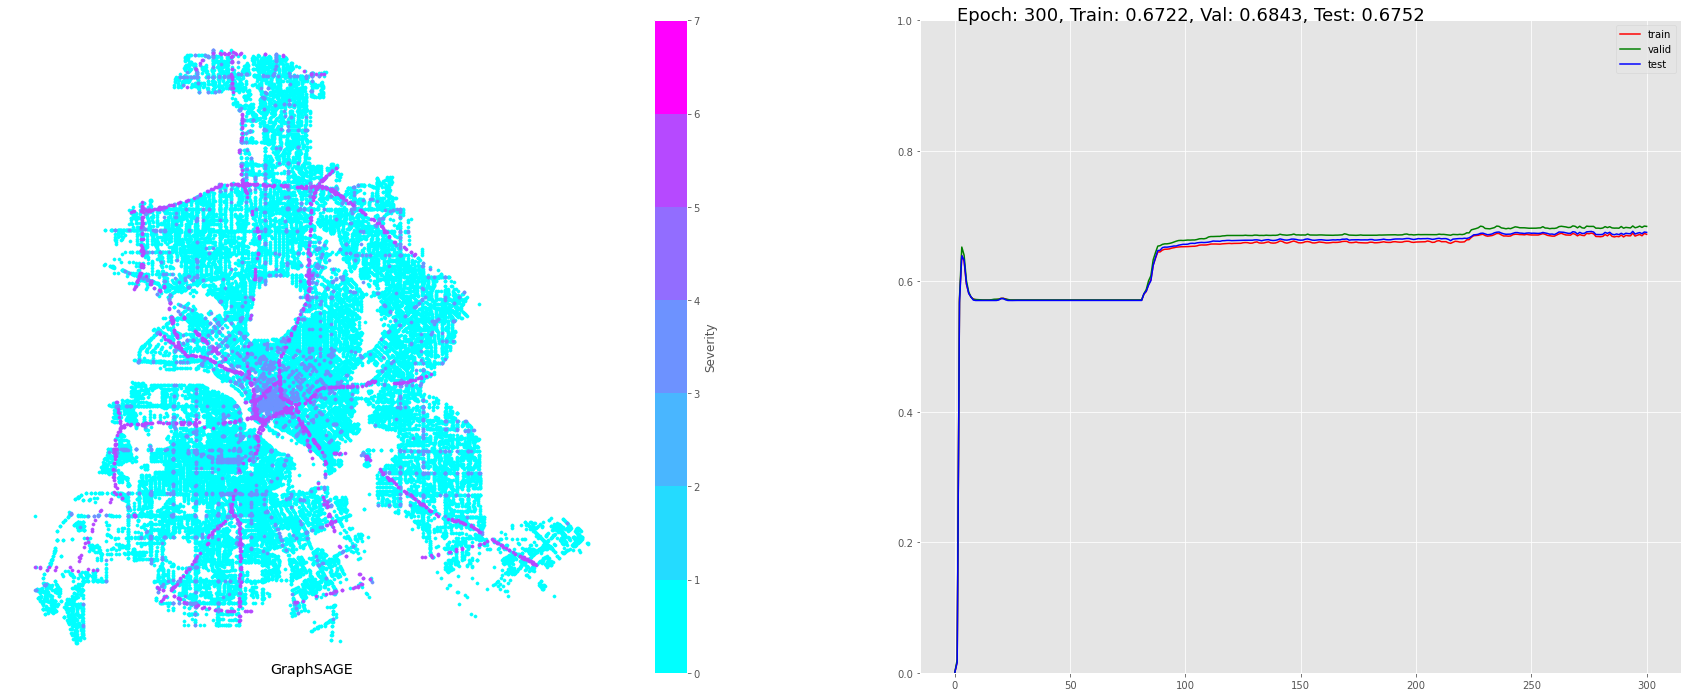

F measure 0.67621 | Test Accuracy 0.73065
Execution time: 13.3900 seconds


In [18]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim=d):
        super(GraphSAGE, self).__init__()
        self.conv1 = pyg_nn.SAGEConv(dataset.num_features, dim)
        self.conv2 = pyg_nn.SAGEConv(dim, dim*2, normalize=True)
        self.fc1 = nn.Linear(dim*2, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = GraphSAGE().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GraphSAGE')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('GraphSAGE',) + res + (t,))
print("Execution time: %.4f seconds" % t)

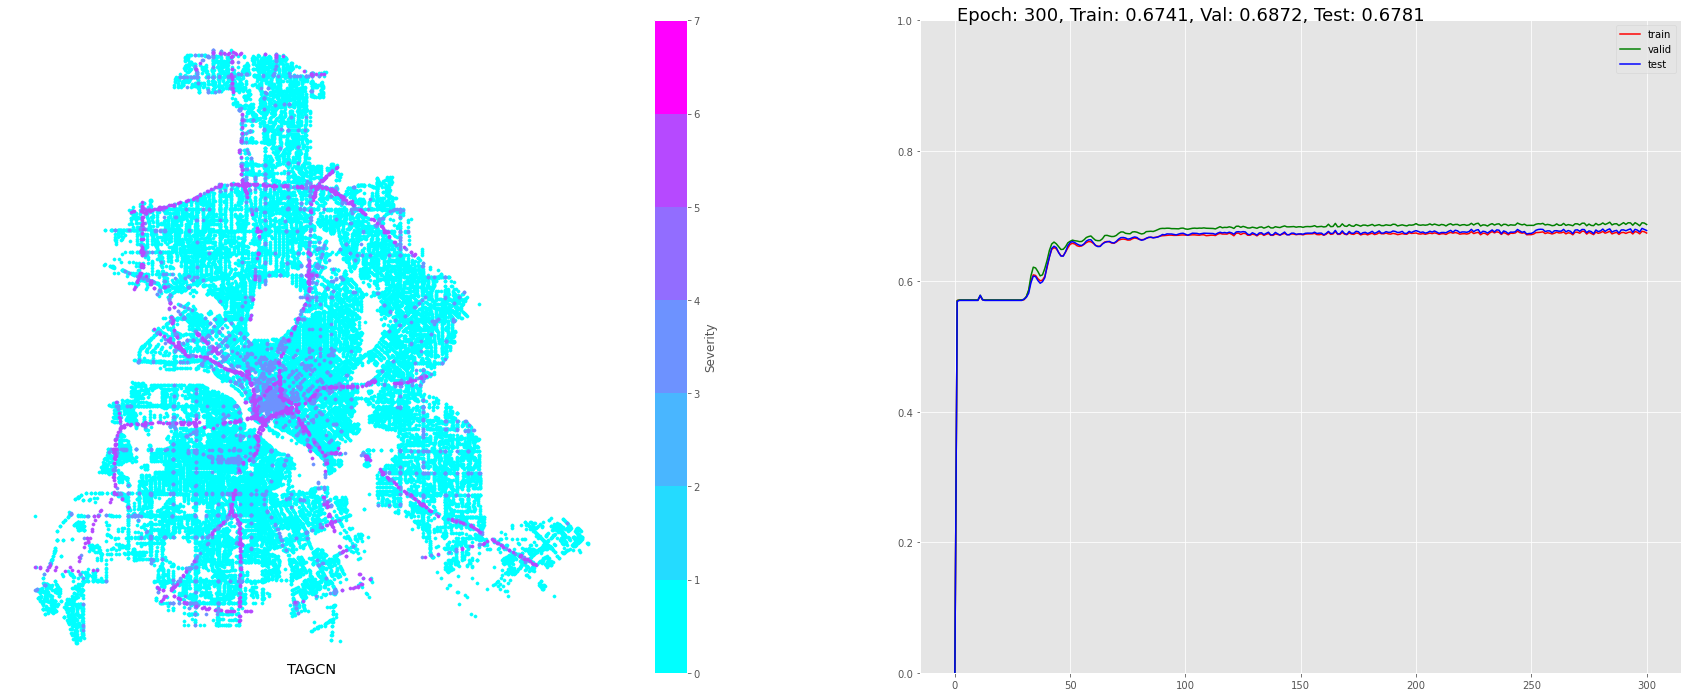

F measure 0.68054 | Test Accuracy 0.73176
Execution time: 15.1400 seconds


In [19]:
class TAGCN(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(TAGCN, self).__init__()
        self.conv1 = pyg_nn.TAGConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.TAGConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = TAGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'TAGCN')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('TAGCN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

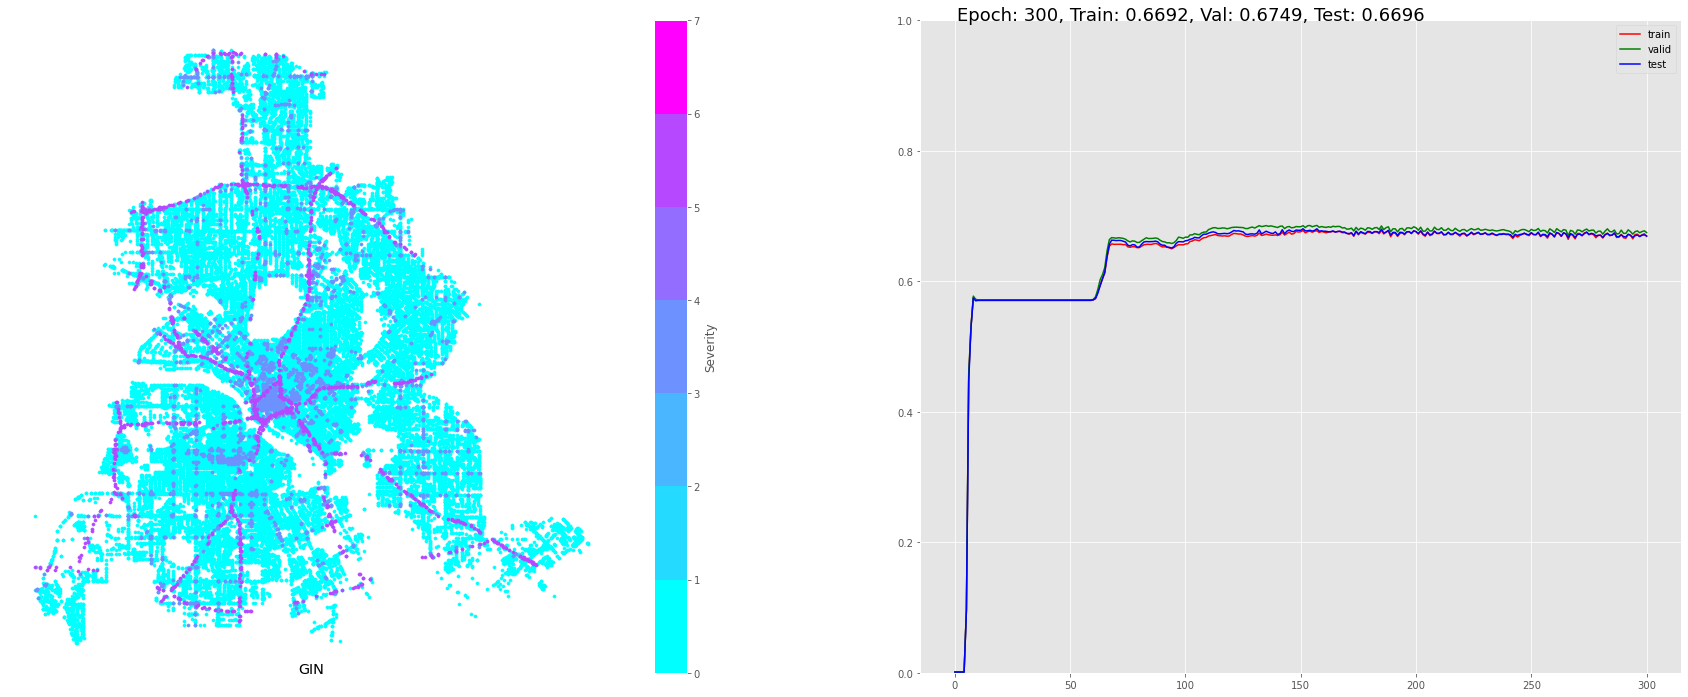

F measure 0.68065 | Test Accuracy 0.72552
Execution time: 13.0700 seconds


In [20]:
class GIN(torch.nn.Module):
    def __init__(self, dim=d):
        super(GIN, self).__init__()
        nn1 = nn.Sequential(nn.Linear(dataset.num_features, dim*2), nn.ReLU(), nn.Linear(dim*2, dim))
        nn2 = nn.Sequential(nn.Linear(dim, dim*2), nn.ReLU(), nn.Linear(dim*2, dim))
        self.conv1 = pyg_nn.GINConv(nn1)
        self.conv2 = pyg_nn.GINConv(nn2)
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = GIN().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GIN')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('GIN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

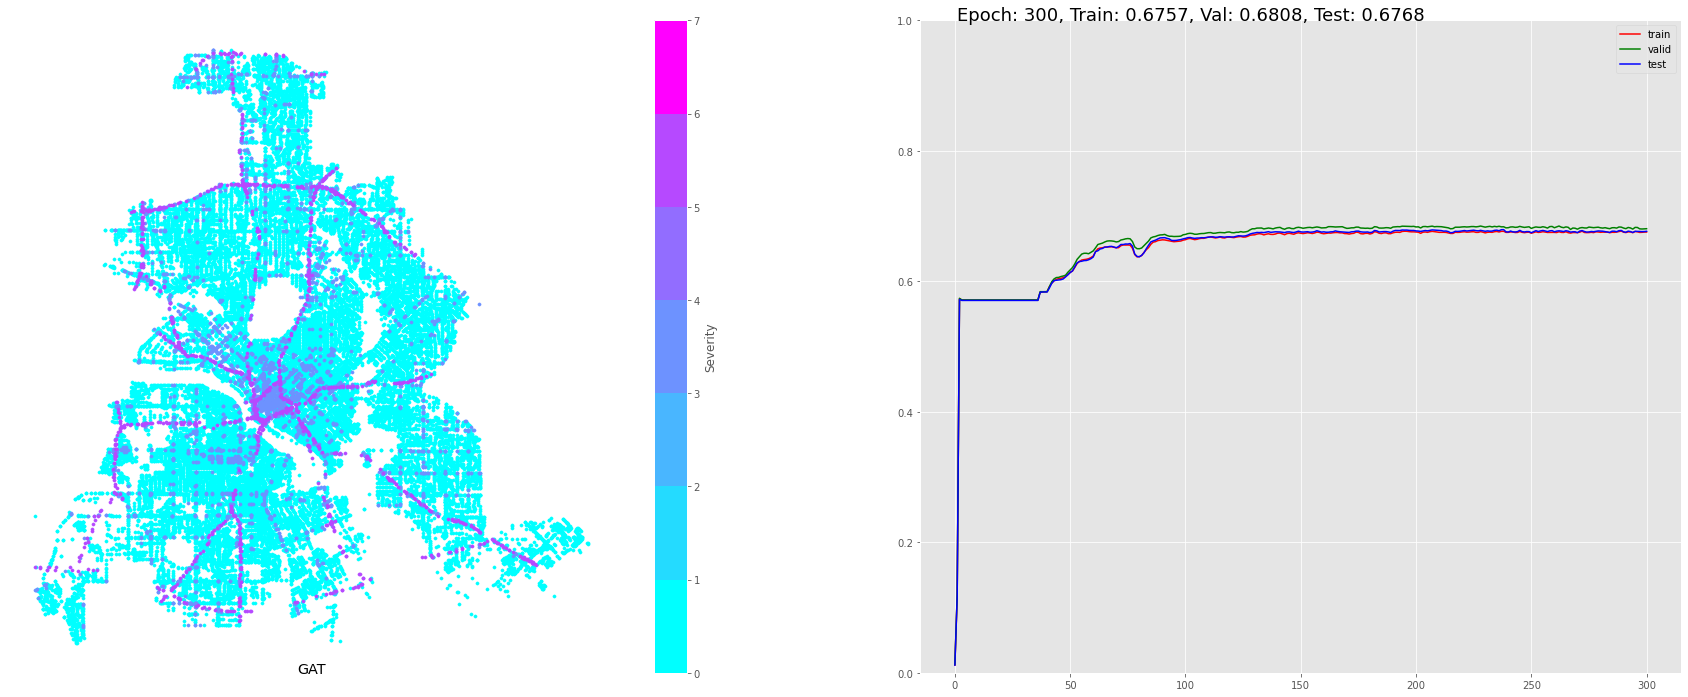

F measure 0.67752 | Test Accuracy 0.72954
Execution time: 21.7800 seconds


In [21]:
class GAT(torch.nn.Module):
    def __init__(self, dim=d):
        super(GAT, self).__init__()
        self.conv1 = pyg_nn.GATConv(dataset.num_features, dim, edge_dim=edge_attr_all.shape[1]) 
        self.conv2 = pyg_nn.GATConv(dim, dim, edge_dim=edge_attr_all.shape[1]) 
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = GAT().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GAT')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('GAT',) + res + (t,))
print("Execution time: %.4f seconds" % t)

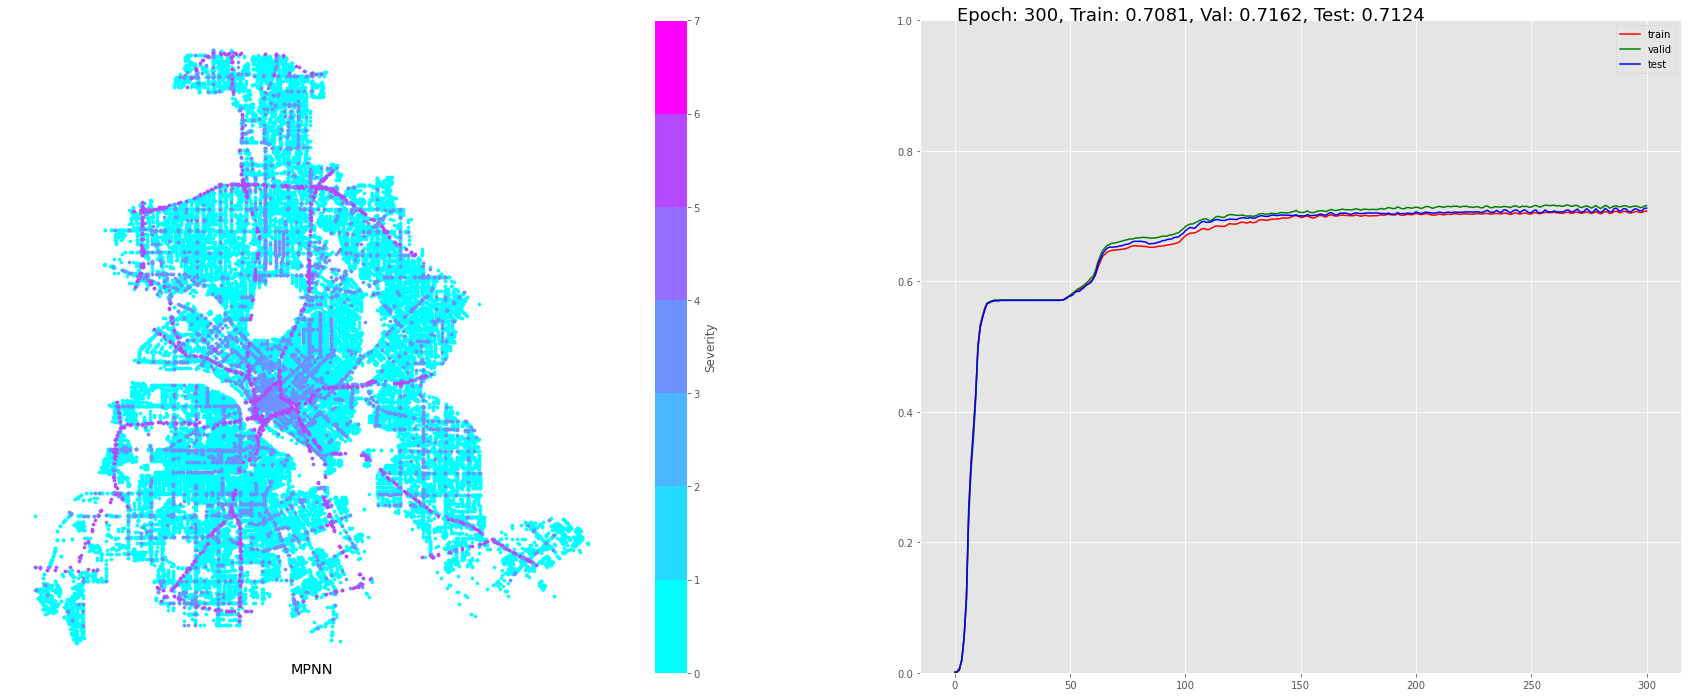

F measure 0.70962 | Test Accuracy 0.74286
Execution time: 51.5300 seconds


In [22]:
class MPNN(torch.nn.Module):
    def __init__(self, dim=d):
        super(MPNN, self).__init__()
        nn1 = nn.Sequential(nn.Linear(edge_attr_all.shape[1], 16), nn.ReLU(), nn.Linear(16, dataset.num_features*dim))
        self.conv1 = pyg_nn.NNConv(dataset.num_features, dim, nn1)
        nn2 = nn.Sequential(nn.Linear(edge_attr_all.shape[1], 16), nn.ReLU(), nn.Linear(16, dim*dim))
        self.conv2 = pyg_nn.NNConv(dim, dim, nn2)
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all #data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = MPNN().to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'MPNN')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('MPNN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

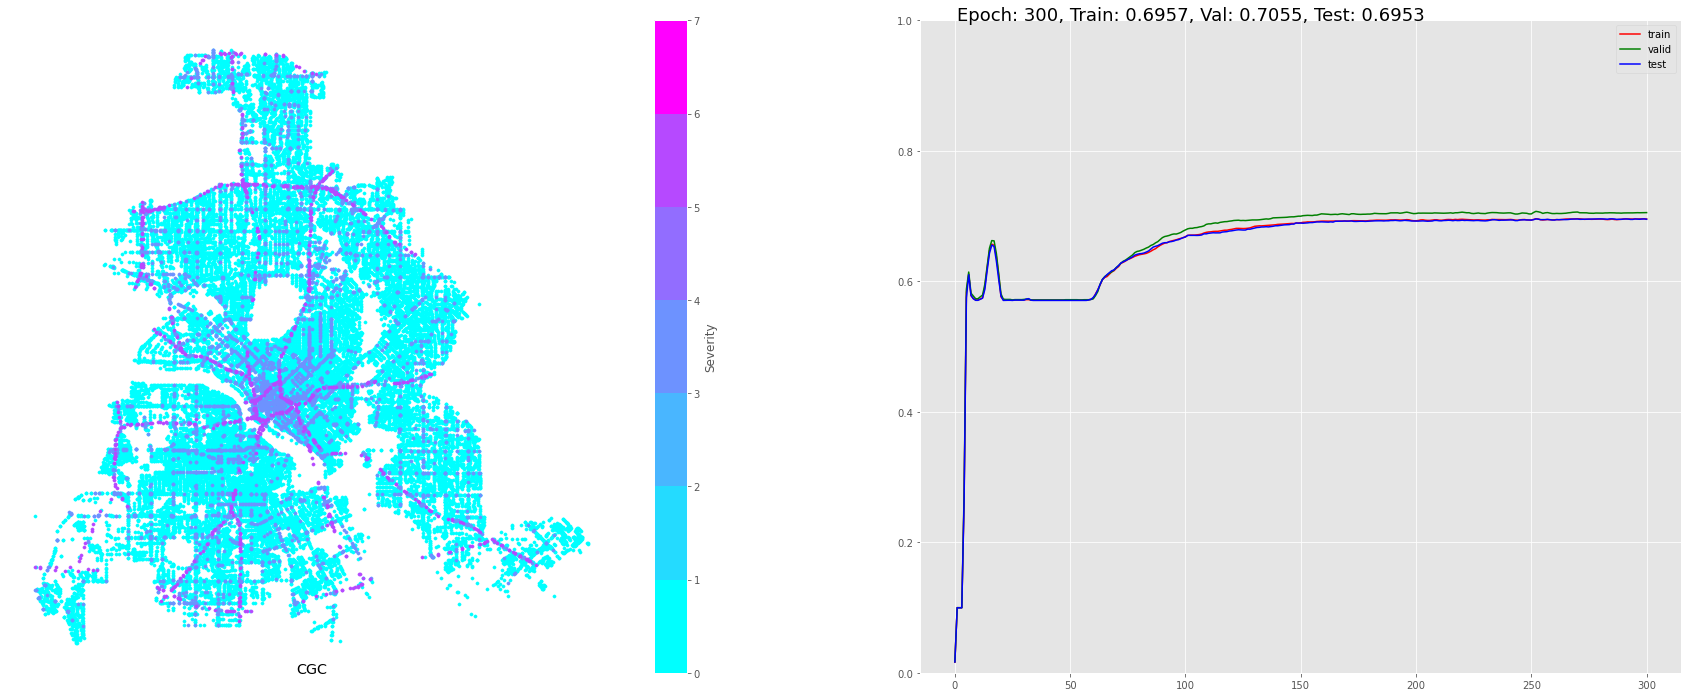

F measure 0.69587 | Test Accuracy 0.73953
Execution time: 26.5200 seconds


In [23]:
class CGC(torch.nn.Module):
    """crystal graph convolutional"""
    def __init__(self, dim=d):
        super(CGC, self).__init__()
        self.conv1 = pyg_nn.CGConv(dataset.num_features, edge_attr_all.size(-1))
        self.conv2 = pyg_nn.CGConv(dataset.num_features, edge_attr_all.size(-1)) 
        self.fc1 = nn.Linear(dataset.num_features, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all
        x = F.relu(self.conv1(x, edge_index, edge_attr)) # 
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)


start_time = time.time()
model = CGC().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'CGC')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('CGC',) + res + (t,))
print("Execution time: %.4f seconds" % t)

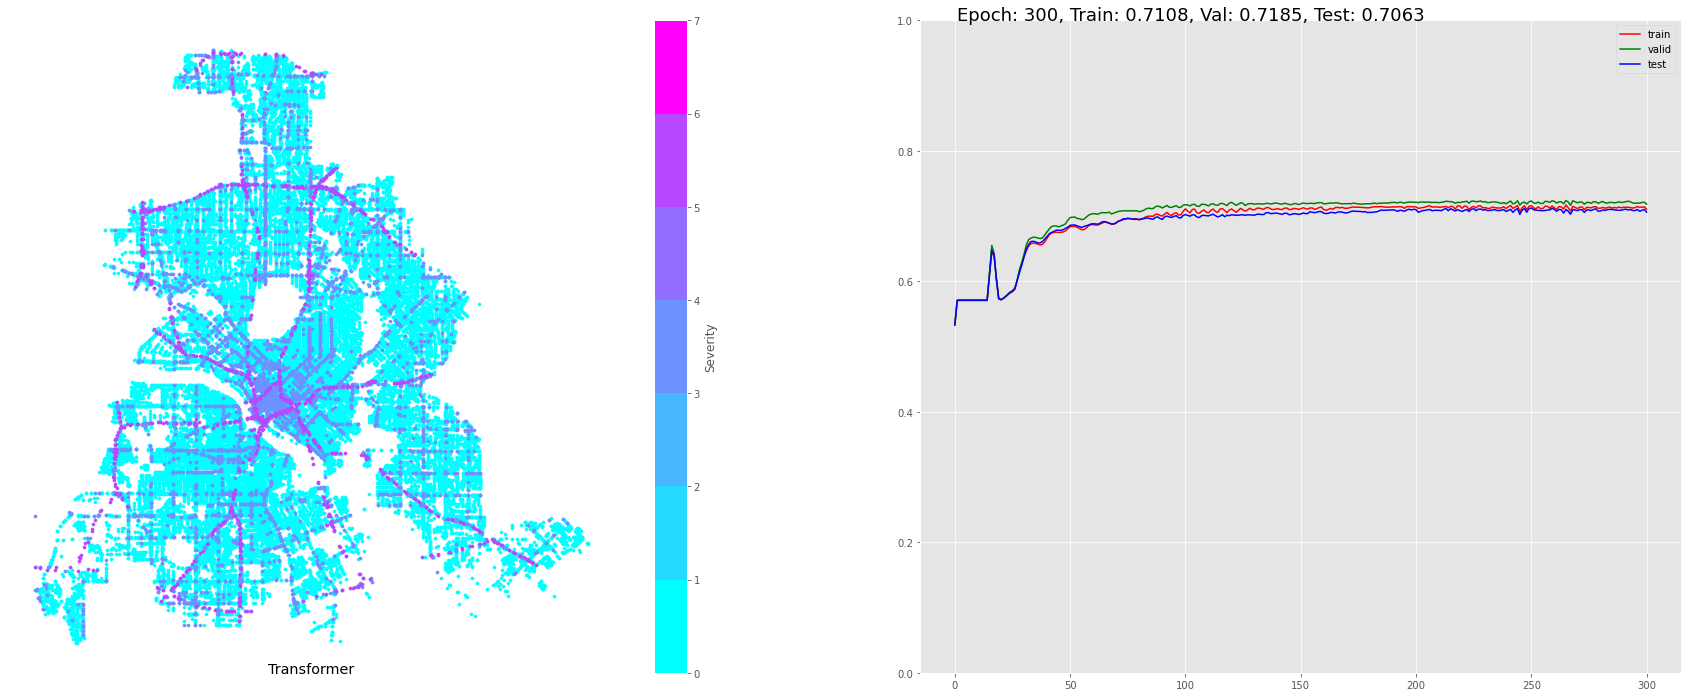

F measure 0.71029 | Test Accuracy 0.73662
Execution time: 29.2000 seconds


In [24]:
class GraphTransformer(torch.nn.Module):
    def __init__(self, dim=d):
        super(GraphTransformer, self).__init__()
        self.conv1 = pyg_nn.TransformerConv(dataset.num_features, dim, edge_dim=edge_attr_all.shape[1]) 
        self.conv2 = pyg_nn.TransformerConv(dim, dim, edge_dim=edge_attr_all.shape[1]) 
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = GraphTransformer().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'Transformer')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('Transformer',) + res + (t,))
print("Execution time: %.4f seconds" % t)

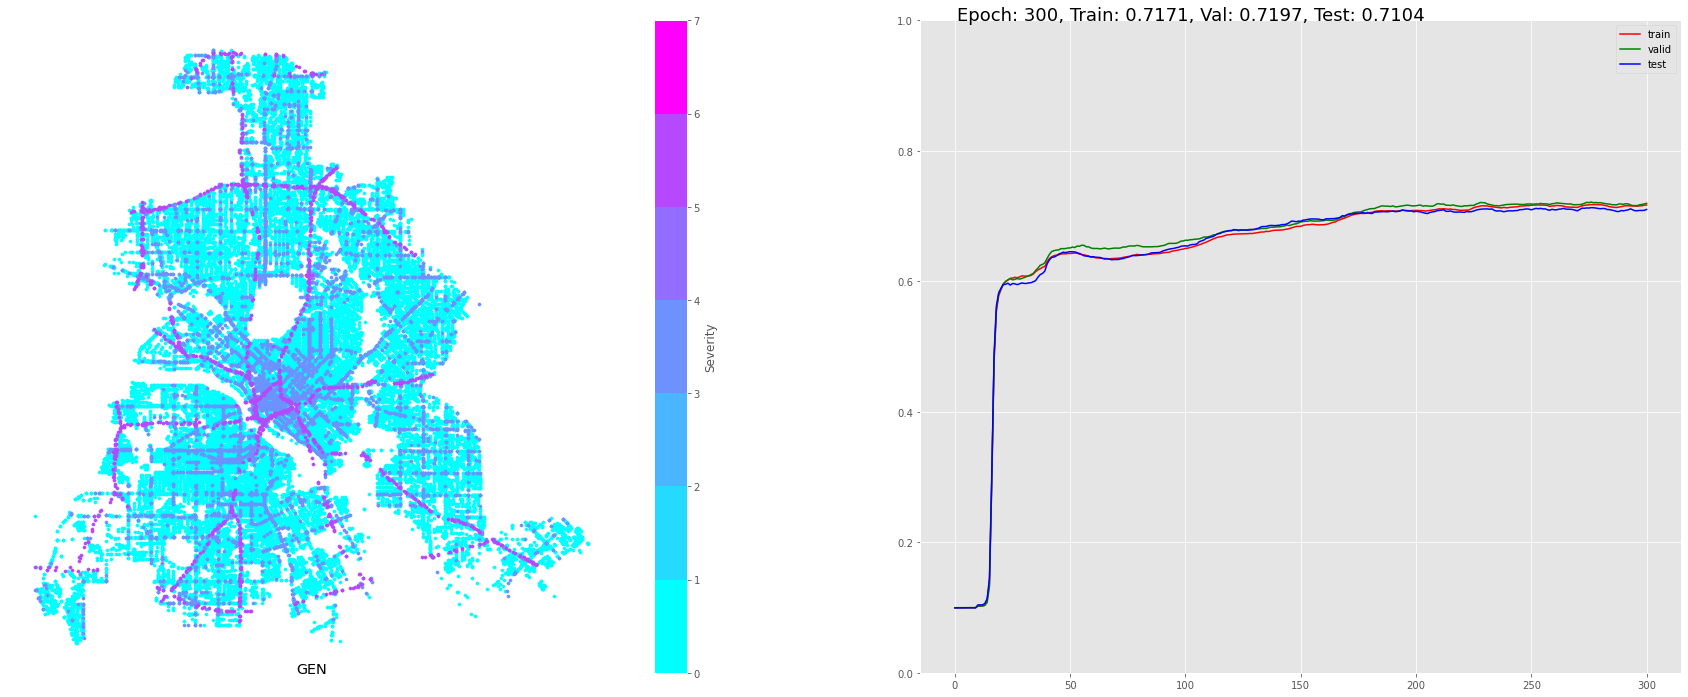

F measure 0.71305 | Test Accuracy 0.73883
Execution time: 27.6800 seconds


In [25]:
class GEN(torch.nn.Module):
    def __init__(self, dim=d):
        super(GEN, self).__init__()
        self.node_encoder = nn.Linear(data.x.size(-1), dim)
        self.edge_encoder = nn.Linear(edge_attr_all.size(-1), dim)
        self.conv1 = pyg_nn.GENConv(dim, dim) 
        self.conv2 = pyg_nn.GENConv(dim, dim)
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = self.node_encoder(data.x), data.edge_index, self.edge_encoder(edge_attr_all)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = GEN().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GEN')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('GEN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

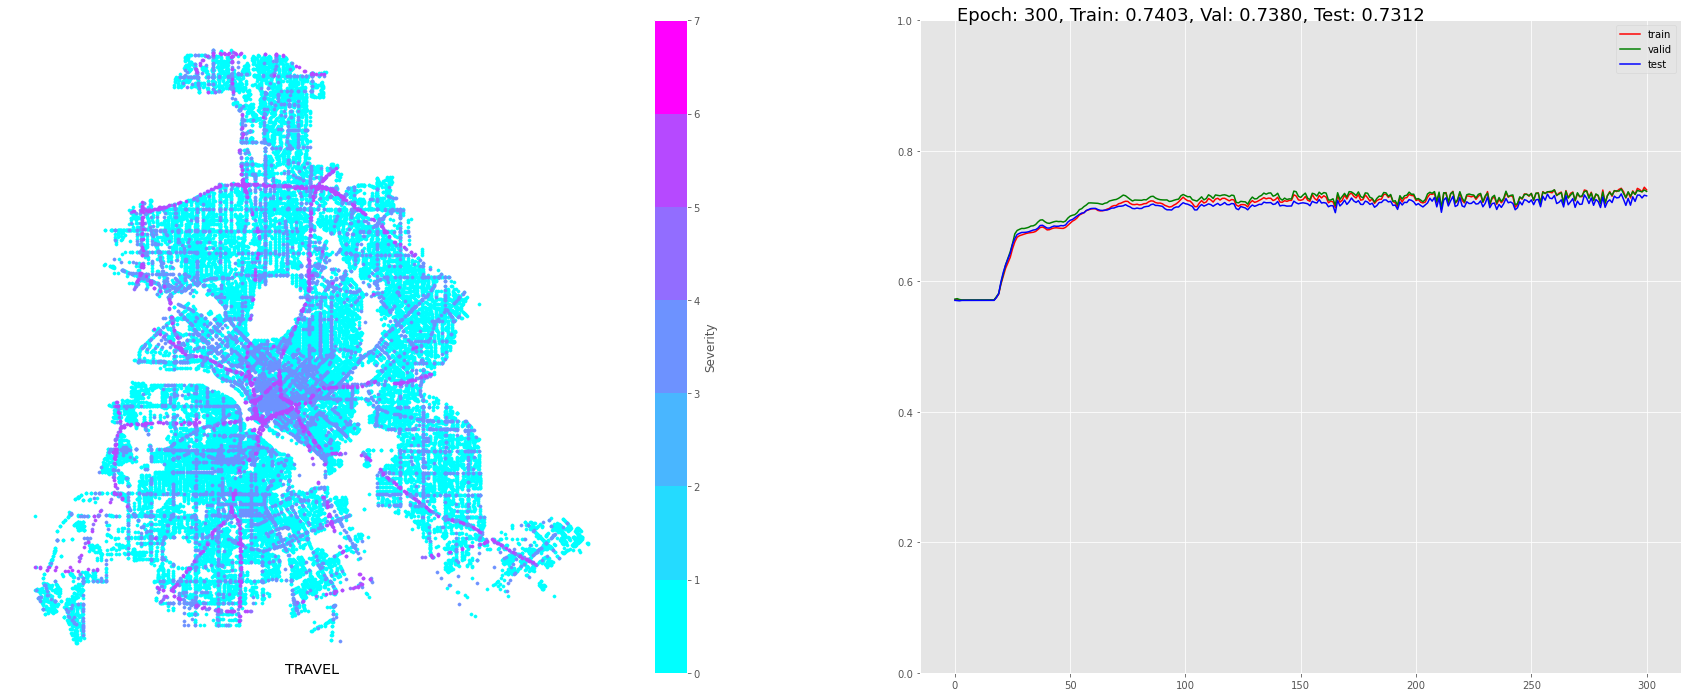

F measure 0.73413 | Test Accuracy 0.74785
Execution time: 27.7200 seconds


In [26]:
component_dir = np.concatenate((data.edge_attr.cpu(), data.edge_attr_dir.cpu()), axis=1)
component_ang = np.concatenate((data.edge_attr.cpu(), data.edge_attr_ang.cpu()), axis=1)
component_dir = StandardScaler().fit_transform(component_dir)
component_ang = StandardScaler().fit_transform(component_ang)
data.component_dir = torch.tensor(component_dir).float().to(device)
data.component_ang = torch.tensor(component_ang).float().to(device)


class TRAVELNet(torch.nn.Module):
    def __init__(self, dim=d):
        super(TRAVELNet, self).__init__()
        convdim = 8
        self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.edge_encoder_dir = nn.Sequential(nn.Linear(data.component_dir.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.edge_encoder_ang = nn.Sequential(nn.Linear(data.component_ang.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        nn1 = nn.Sequential(nn.Linear(dim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1 = TRAVELConv(dim, convdim, nn1)
        nn2 = nn.Sequential(nn.Linear(2*convdim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2 = TRAVELConv(2*convdim, dataset.num_classes, nn2)
        self.bn1 = nn.BatchNorm1d(convdim*2)
        nn1_2 = nn.Sequential(nn.Linear(dim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1_2 = TRAVELConv(dim, convdim, nn1_2)
        nn2_2 = nn.Sequential(nn.Linear(2*convdim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2_2 = TRAVELConv(2*convdim, dataset.num_classes, nn2_2)
        self.bn2 = nn.BatchNorm1d(dataset.num_classes*2)
        self.fc = nn.Linear(dataset.num_classes*2, dataset.num_classes)

    def forward(self):
        x, edge_index = self.node_encoder(data.x), data.edge_index
        edge_attr_dir, edge_attr_ang = self.edge_encoder_dir(data.component_dir), self.edge_encoder_ang(data.component_ang)
        x1 = F.relu(self.conv1(x, edge_index, edge_attr_dir))
        x2 = F.relu(self.conv1_2(x, edge_index, edge_attr_ang))
        x = torch.cat((x1, x2), axis=1)
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x1 = F.relu(self.conv2(x, edge_index, edge_attr_dir))
        x2 = F.relu(self.conv2_2(x, edge_index, edge_attr_ang))
        x = torch.cat((x1, x2), axis=1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = TRAVELNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('TRAVEL',) + res + (t,))
print("Execution time: %.4f seconds" % t)

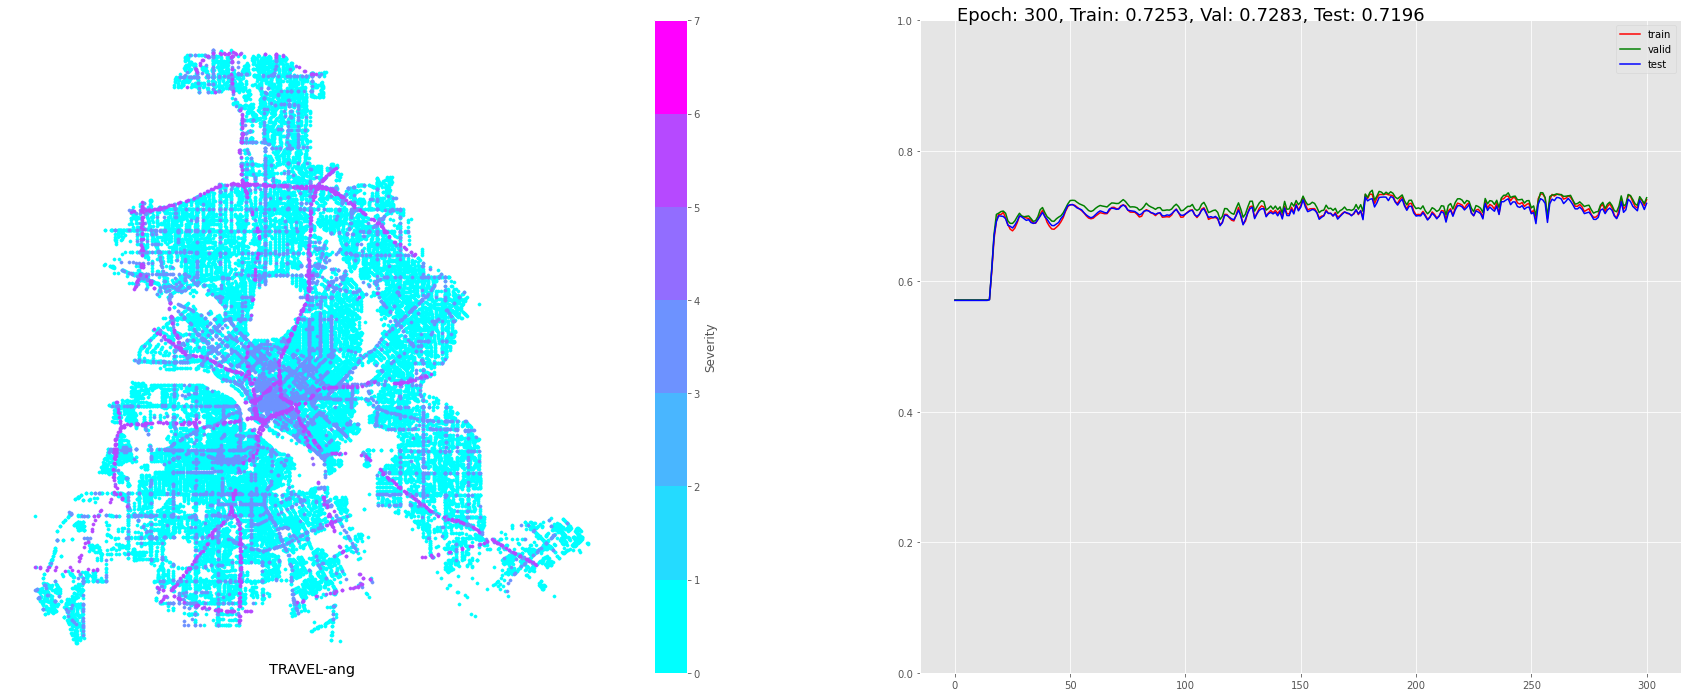

F measure 0.72683 | Test Accuracy 0.73273
Execution time: 19.8300 seconds


In [28]:
class TRAVELAng(torch.nn.Module):
    def __init__(self, dim=d):
        super(TRAVELAng, self).__init__()
        self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.edge_encoder_ang = nn.Sequential(nn.Linear(data.component_ang.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        nn1 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.conv1 = TRAVELConv(dim, dim, nn1)
        self.bn1 = nn.BatchNorm1d(dim)
        nn2 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.conv2 = TRAVELConv(dim, dim, nn2)
        self.fc = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index = self.node_encoder(data.x), data.edge_index
        edge_attr_encoded = self.edge_encoder_ang(data.component_ang)
        x = F.relu(self.conv1(x, edge_index, edge_attr_encoded))
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr_encoded))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


start_time = time.time()
model = TRAVELAng().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL-ang')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('TRAVEL-ang',) + res + (t,))
print("Execution time: %.4f seconds" % t)

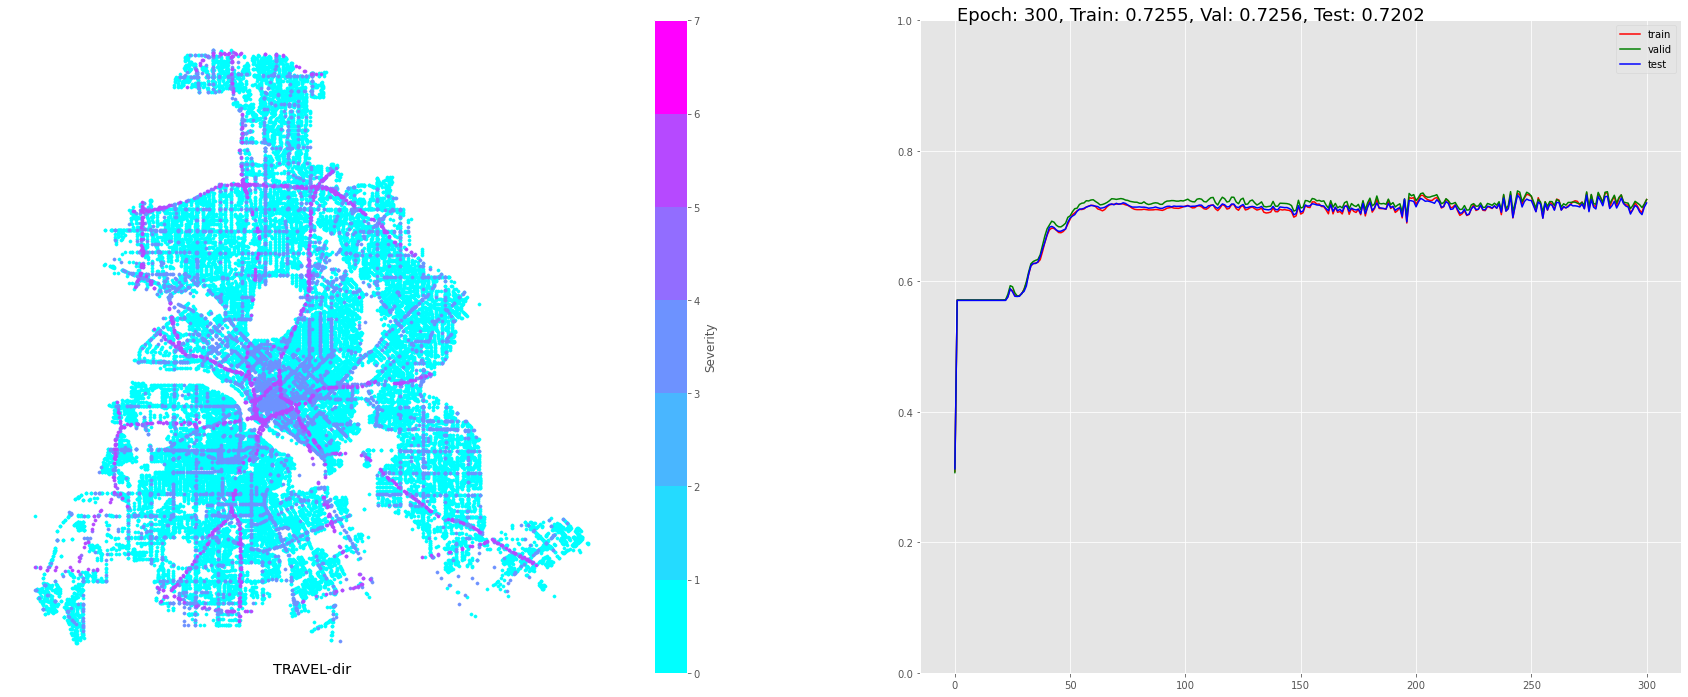

F measure 0.73232 | Test Accuracy 0.74424
Execution time: 19.5800 seconds


In [29]:
class TRAVELDir(torch.nn.Module):
    def __init__(self, dim=d):
        super(TRAVELDir, self).__init__()
        self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.edge_encoder_dir = nn.Sequential(nn.Linear(data.component_dir.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        nn1 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.conv1 = TRAVELConv(dim, dim, nn1)
        self.bn1 = nn.BatchNorm1d(dim)
        nn2 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.conv2 = TRAVELConv(dim, dim, nn2)
        self.fc = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index = self.node_encoder(data.x), data.edge_index
        edge_attr_encoded = self.edge_encoder_dir(data.component_dir)
        x = F.relu(self.conv1(x, edge_index, edge_attr_encoded))
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr_encoded))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)    


start_time = time.time()
model = TRAVELDir().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL-dir')
t = round(time.time() - start_time, 2)
all_res.append((str(cnt+1),) + (e[0]+' '+e[1],) + ('TRAVEL-dir',) + res + (t,))
print("Execution time: %.4f seconds" % t)

In [31]:
results = pd.DataFrame(all_res, columns=['Dataset', 'City', 'Method', 'Weighted F1', 'Accuracy', 'Time'])
results

Dataset       City       Method  Weighted F1  Accuracy   Time
0        1  Dallas TX      XGBoost        66.00     72.70   2.16
1        2  Dallas TX          MLP        65.16     72.27  17.06
2        2  Dallas TX          GCN        66.16     71.89  15.28
3        2  Dallas TX      ChebNet        67.47     73.25  14.53
4        2  Dallas TX      ARMANet        67.06     73.07  13.91
5        2  Dallas TX    GraphSAGE        67.62     73.07  13.39
6        2  Dallas TX        TAGCN        68.05     73.18  15.14
7        2  Dallas TX          GIN        68.07     72.55  13.07
8        2  Dallas TX          GAT        67.75     72.95  21.78
9        2  Dallas TX         MPNN        70.96     74.29  51.53
10       2  Dallas TX          CGC        69.59     73.95  26.52
11       2  Dallas TX  Transformer        71.03     73.66  29.20
12       2  Dallas TX          GEN        71.31     73.88  27.68
13       2  Dallas TX       TRAVEL        73.41     74.79  27.72
14       2  Dallas TX   TRAVEL-ang        72.68     73.27  19.83
15       2  Dallas TX   TRAVEL-dir        73.23     74.42  19.58